### Quick notebook to plot all the dodgy events from a specific data file

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

### ^^^^^^^ CHANGE THE ENVIRONMENT IMPORTS


import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf

from invisible_cities.io.dst_io import load_dst
import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
def plt_sphere(list_center, list_radius, col = 'g', label = 'template'):
  for c, r in zip(list_center, list_radius):
    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    s1 = ax.plot_surface(x+c[0], y+c[1], z+c[2], color=col, alpha=0.1*np.random.random()+0.9, zorder = 3, label = label)


def plt_MCsphere(list_center, list_radius, label = 'template', cmap = 'cm.coolwarm'):
  for c, r in zip(list_center, list_radius):
    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    s1 = ax.plot_surface(x+c[0], y+c[1], z+c[2], cmap = cmap, alpha=0.1*np.random.random()+0.9, zorder = 3, label = label)


def add_binclass(mchits, mcpart, signal_creator = 'conv'):
    '''
    Adds binary class to each hit depending on if its event is considered as signal or background.
    The two possible classes for the events are:
        0 - background
        1 - signal
    Process:
        - Selects particles that had any hit in the active.
        - Selects only e-/e+
        - If there are 2 particles in an event that are created by a certain process,
          labels the event as signal. 
        - Otherwise, as background.
    For double escape data, the creator process is signal_creator = 'conv' (i.e. 208Tl data).
    For 0nubb data, the creator process is signal_creator = 'none'.

    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file, from table MC/hits.
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file, from table MC/particles.
        signal_creator: STR
    If 'conv', signal will be the double escape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        mchits_binclass: DATAFRAME
    The mchits df with a new column containing the binclass.
    '''

    # Select only those particles that actually left any hit in the active
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id'])
    hits_part = hits_part[mcpart.columns].drop_duplicates()

    # Select e+/e-
    hits_part = hits_part[np.isin(hits_part.particle_name, ['e+', 'e-'])]
    
    # Create a selector of signal/background
    selector = lambda x: 1 if int(sum(x == signal_creator)) == 2 else 0

    class_label = hits_part.groupby('event_id').creator_proc.apply(selector).astype(int)
    class_label.name = 'binclass'
    mchits_binclass  = pd.merge(mchits, class_label, on = 'event_id')
    
    return mchits_binclass

def get_extremes(file, signal_creator = 'conv'):
    '''
    Gets the extremes of the MC track. 
    It also gives them a label, called 'ext', which can be:
        1 - end   of background track, random for signal track
        2 - start of background track, random for signal track (for similarity with 'blob2')
    Process:
        - Do binary classification of the events
        - Select the main particles in the event (e+e- or e-e- for signal,
          the most energetic e- for background)
        - Select the extremes (last hits for signal, first/last for background)
    
    Args:
        file: STR
    Path to any file with MC information.
        signal_creator: STR
    If 'conv', signal will be the double scape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        track_ext: DATAFRAME
    The extreme hits of each event with a label.
    '''

    mcpart = load_dst(file, 'MC', 'particles')
    mchits = load_dst(file, 'MC', 'hits')
    mchits = mchits[mchits.label == 'ACTIVE']
    
    # Add binclass label to the hits
    mchits_label = add_binclass(mchits, mcpart, signal_creator = signal_creator)
    # Add to each hit the particle information
    hits_part = pd.merge(mchits_label, mcpart, on = ['event_id', 'particle_id'])
    # Do the sum on the energy so we can choose the most energetic e- in a bkg event
    per_part_info = hits_part.groupby(['event_id',
                                        'particle_id',
                                        'particle_name',
                                        'binclass',
                                        'creator_proc']).agg({'energy':[('track_ener', sum)], 'hit_id':[('nhits', len)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)

    # Select each type of particle
    ## Signal
    particles_sig = per_part_info[(per_part_info.binclass == 1) &\
                                    np.isin(per_part_info.particle_name, ['e+', 'e-']) &\
                                    (per_part_info.creator_proc == signal_creator)]
    ## Background
    particles_bkg = per_part_info[(per_part_info.binclass == 0) &\
                                    (per_part_info.particle_name == 'e-') &\
                                    (per_part_info.creator_proc.isin(['compt', 'phot', 'none']))]

    particles_bkg = particles_bkg.loc[particles_bkg.groupby('event_id').track_ener.idxmax()]

    # Search for the extremes
    ## Signal
    hits_sig = pd.merge(mchits_label, particles_sig)
    track_ext_sig = hits_sig.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop = True)
    track_ext_sig['ext'] = track_ext_sig.groupby('event_id').cumcount() + 1

    ## Background
    hits_bkg = pd.merge(mchits_label, particles_bkg)

    track_start_bkg = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()]).reset_index(drop=True)
    track_end_bkg   = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop=True)

    ### asigned this label so 2 is like "blob2" 
    track_start_bkg['ext'] = 2
    track_end_bkg['ext']   = 1

    # Join all
    track_ext_bkg = pd.concat([track_start_bkg, track_end_bkg])
    track_ext = pd.concat([track_ext_bkg, track_ext_sig]).sort_values('event_id')
    return track_ext


def plot_blobs(data, dataMC, track_data, evnt_mc_extr, evt):
    '''
    Crap function just made quickly to move the blob plotting out of a loop
    '''
    fig = plt.figure(figsize = (9,9))
    ax = fig.add_subplot(111, projection='3d')





    x = data.X
    y = data.Y
    z = data.Z
    e = data.E

    xt = dataMC.x
    yt = dataMC.y
    zt = dataMC.z
    et = dataMC.energy*1000

    em = e > 0.00005
    ##p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    p = ax.scatter3D(x, y, z, c=e, alpha=0.009, cmap='viridis', zorder=1)
    q = ax.scatter3D(xt, yt, zt, alpha = 0.1, color = 'red', zorder = 0)
    #cb = fig.colorbar(p, ax=ax)
    #cb.set_label('Energy (keV)')


    ax.scatter3D(track_data.blob1_x.values[0], track_data.blob1_y.values[0], track_data.blob1_z.values[0], s = 300, c = 'fuchsia', marker = 'o', zorder = 100, label = 'predicted blob1',depthshade=False)
    ax.scatter3D(track_data.blob2_x.values[0], track_data.blob2_y.values[0], track_data.blob2_z.values[0], s = 350, c = 'red', marker = 'o', zorder = 100, label = 'predicted blob2', depthshade=False)
    for blb, dfext in evnt_mc_extr.groupby('ext'):

        if blb == 1:
            col = 'lime'
        else:
            col = 'navy'
        ax.scatter3D(dfext.x.values[0], dfext.y.values[0], dfext.z.values[0], s = 200, c = col, marker = 'X', label = 'true blob' + str(blb))


    plt.legend()

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')

    #ax.view_init(20, 270)


    # blob parts

    fig.suptitle('3D_deconvolved_plot_' + str(evt))
    plt.show()

### read in isaura data

In [3]:
path = 'data/'
tracking = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'Tracking/Tracks')
df = pd.read_hdf(path + 'beersheba_1_208Tl.h5', 'DECO/Events')
events = np.unique(df.event.to_numpy())

# also load in MC
dfMC = mcio.load_mchits_df(path + 'isaura_1_208Tl.h5').reset_index()
eventsMC = np.unique(dfMC.event_id.to_numpy())
infoMC = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'MC/particles')

## MC extremes from Martins code
mc_extr = get_extremes(path + 'isaura_1_208Tl.h5')

### read dodgy events list

`blob1_anomalies.npy` is events with the difference between true and reconstructed blob 1 position is > 20 mm in magnitude. Equivalent for `blob2_anomalies.npy`

Selected event: 2 (1 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.35349 MeV
Track E: 2.19991


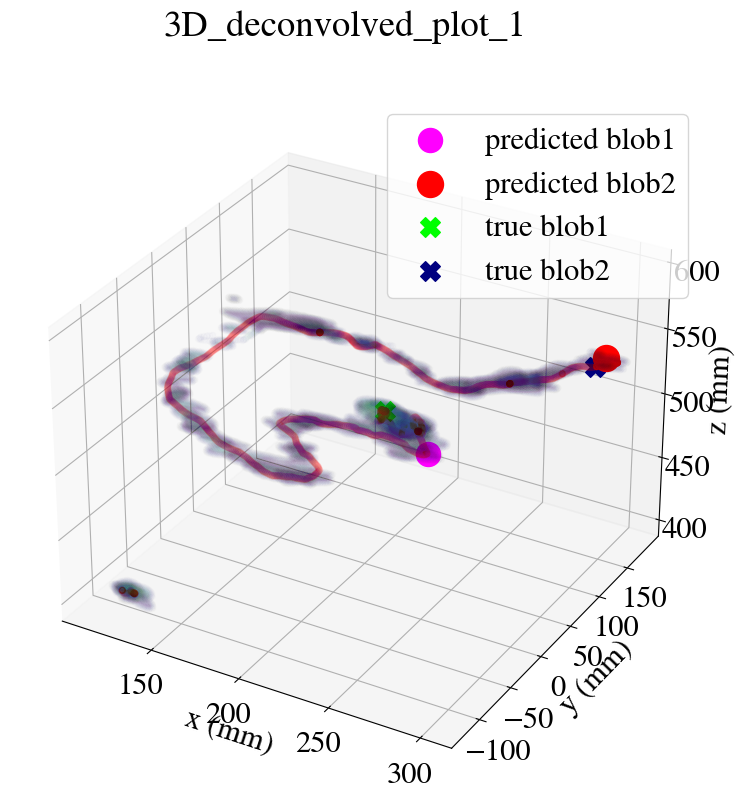

Selected event: 6 (3 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.35378 MeV
Track E: 0.17995


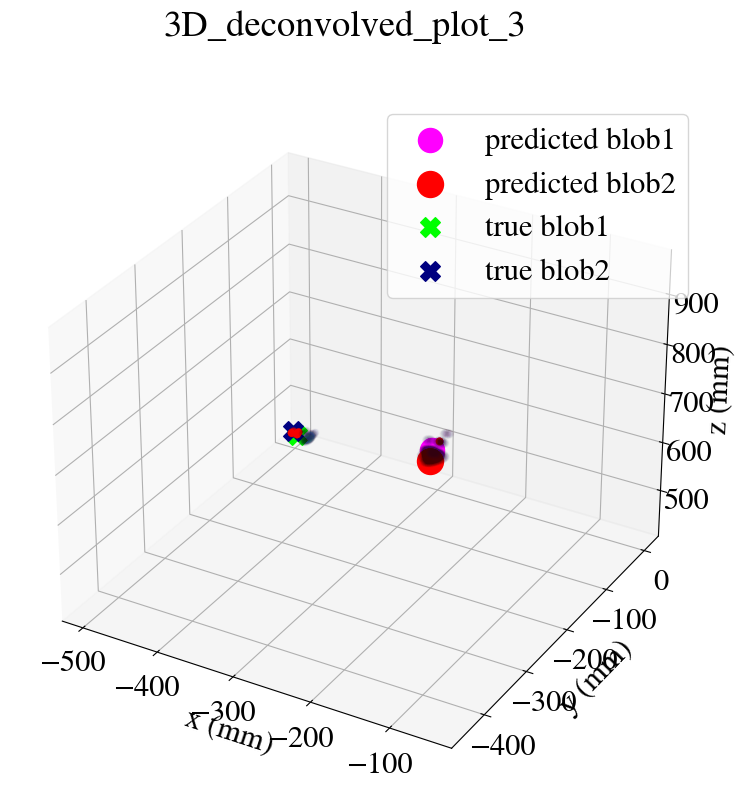

Selected event: 38 (19 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.32361 MeV
Track E: 1.83484


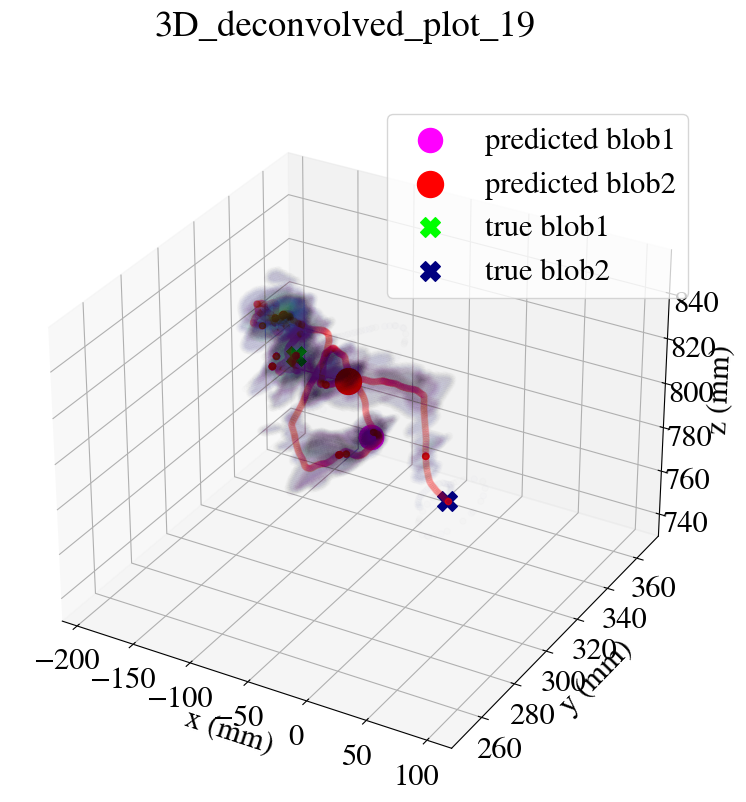

Selected event: 56 (28 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.17596 MeV
Track E: 1.17596


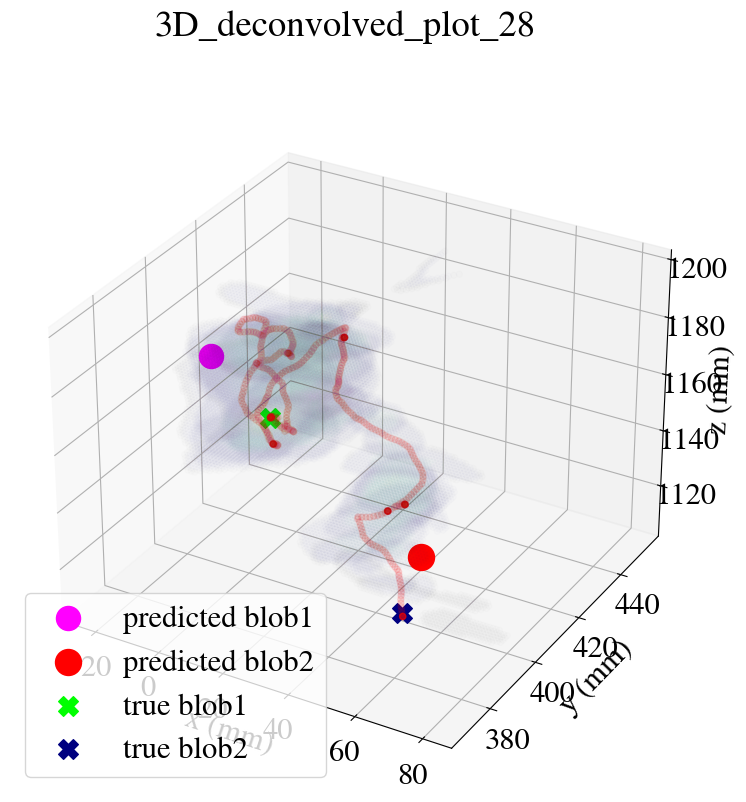

Selected event: 68 (34 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.18138 MeV
Track E: 1.09883


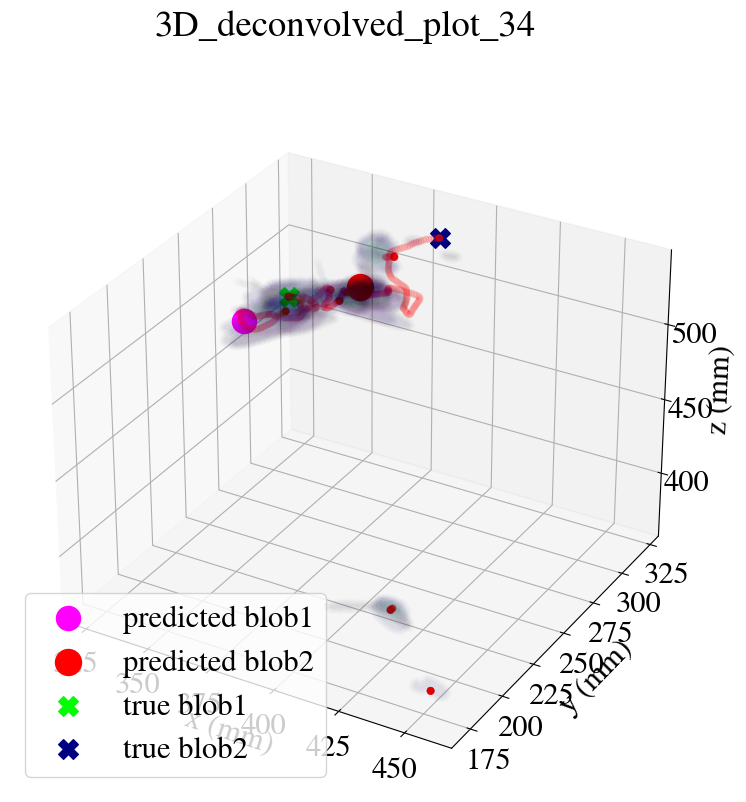

Selected event: 72 (36 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.93083 MeV
Track E: 0.93083


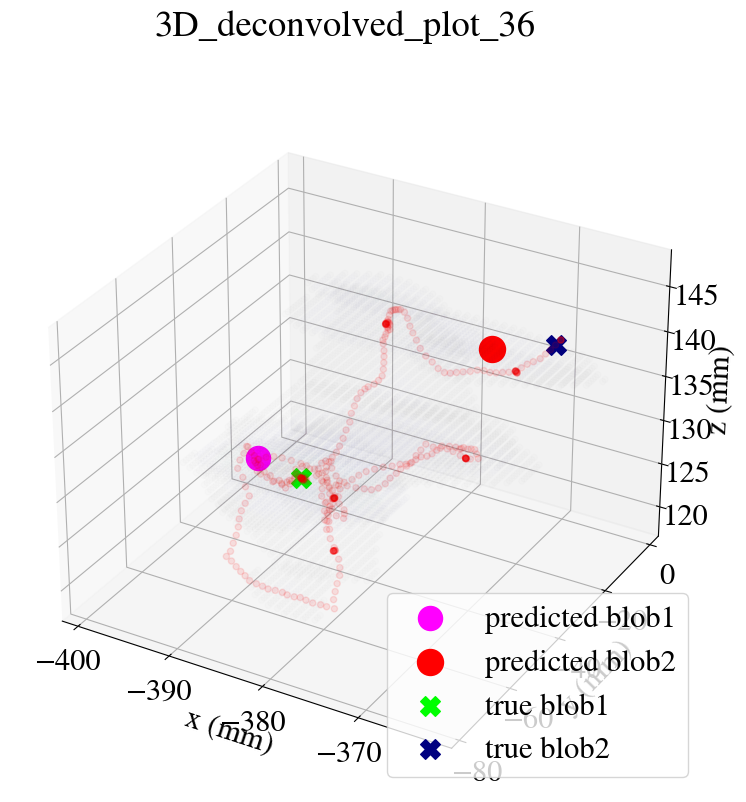

Selected event: 84 (42 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.63550 MeV
Track E: 0.63550


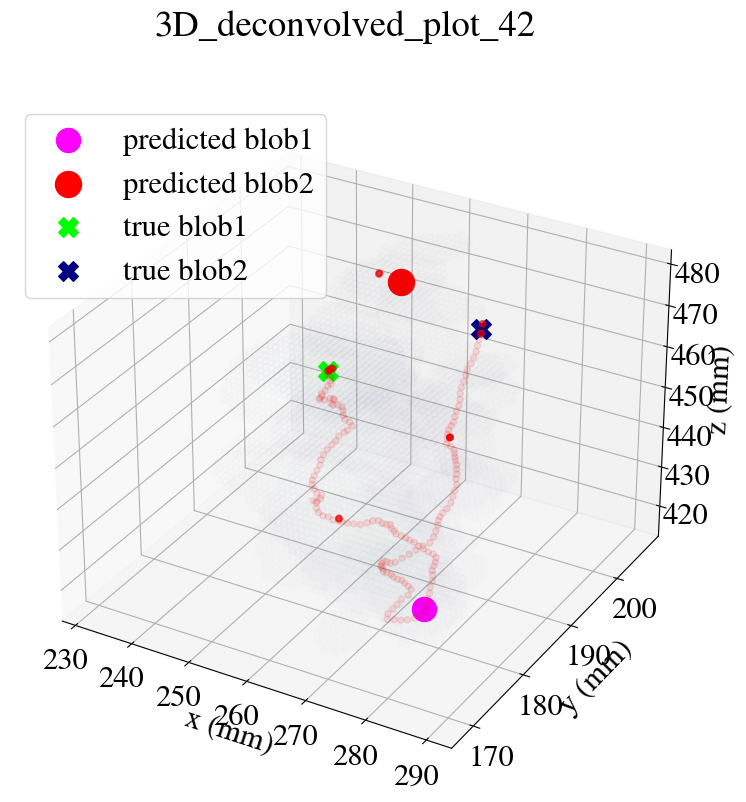

Selected event: 102 (51 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.77027 MeV
Track E: 0.67164


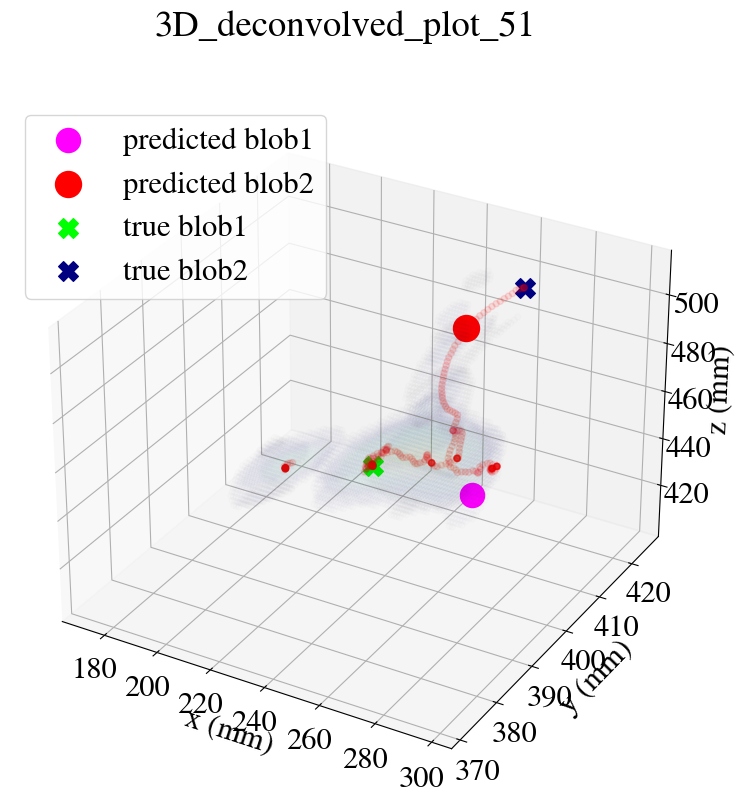

Selected event: 108 (54 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.99394 MeV
Track E: 1.66234


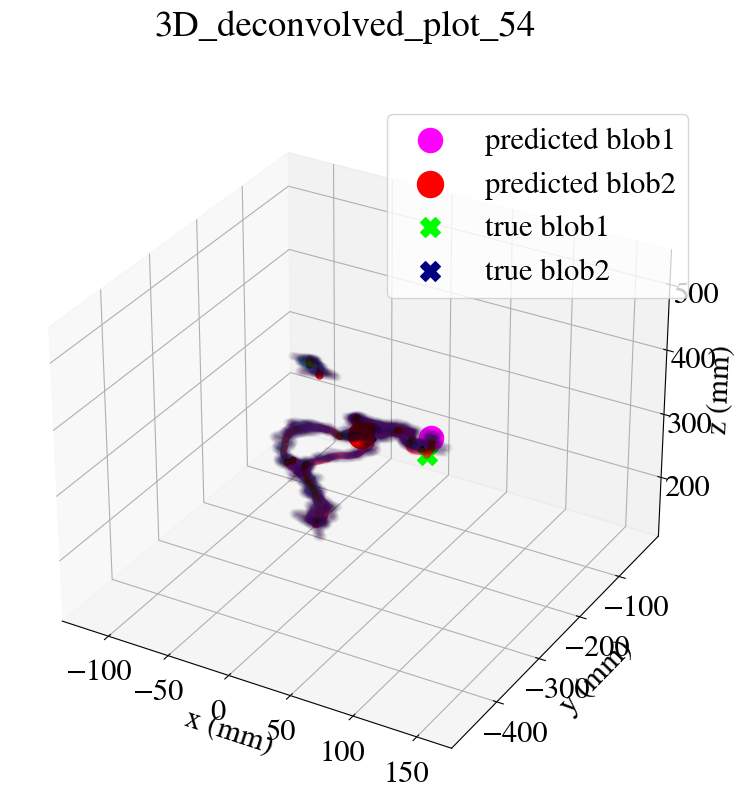

Selected event: 116 (58 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.60892 MeV
Track E: 2.60665


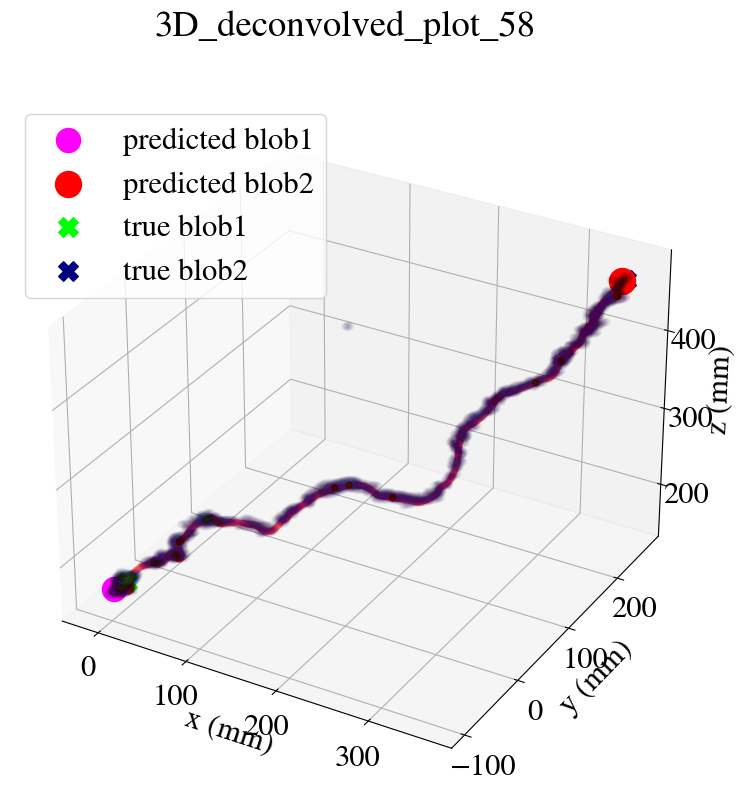

Selected event: 148 (74 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.10956 MeV
Track E: 2.10956


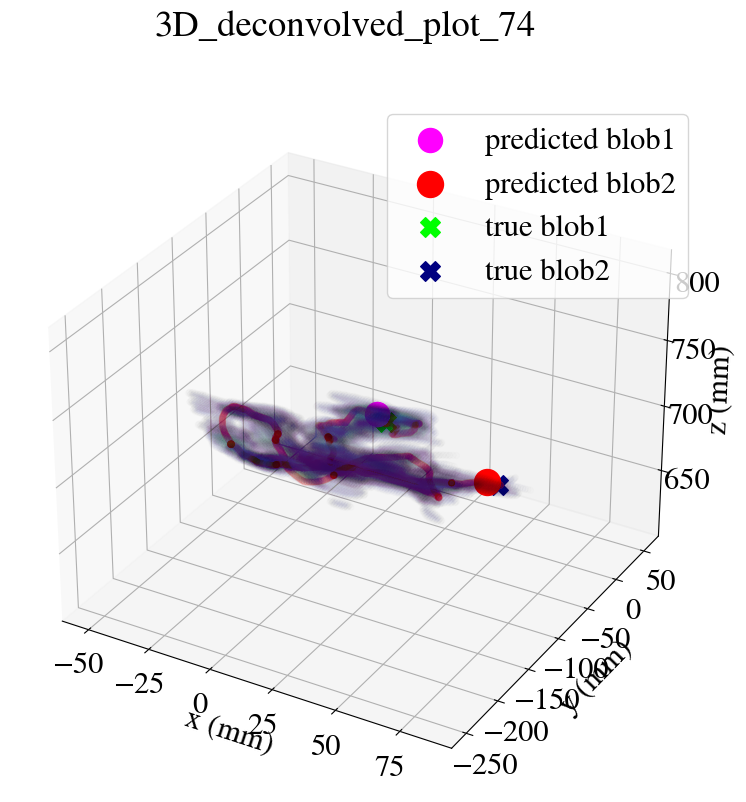

Selected event: 156 (78 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.63179 MeV
Track E: 1.71226


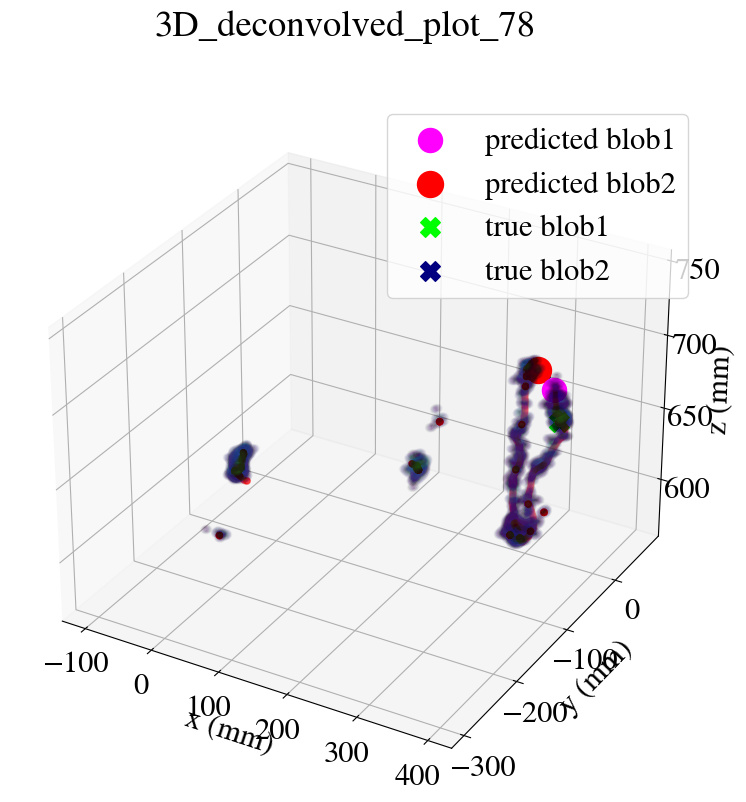

Selected event: 172 (86 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.28453 MeV
Track E: 2.24363


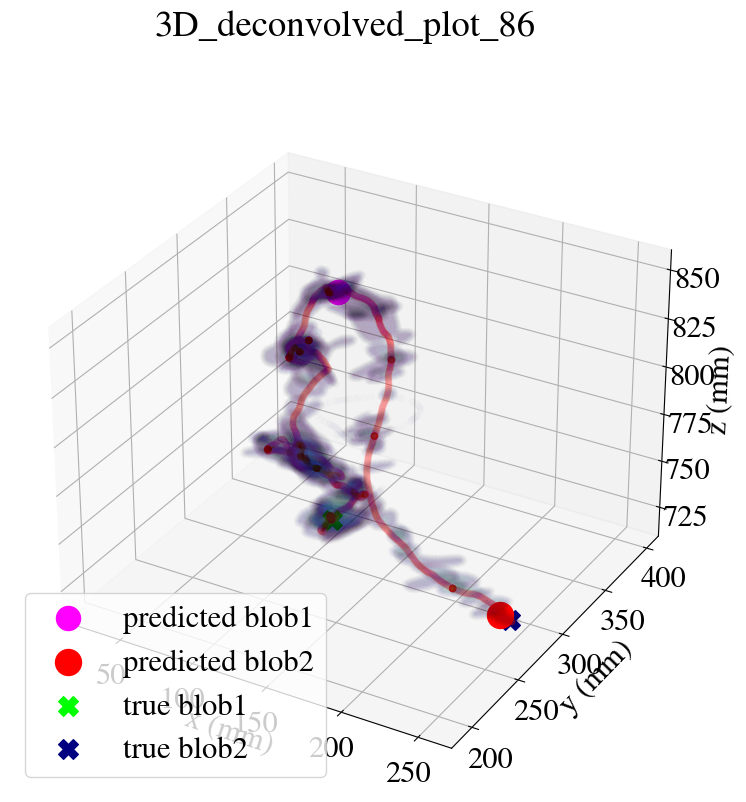

Selected event: 178 (89 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.44304 MeV
Track E: 0.18142


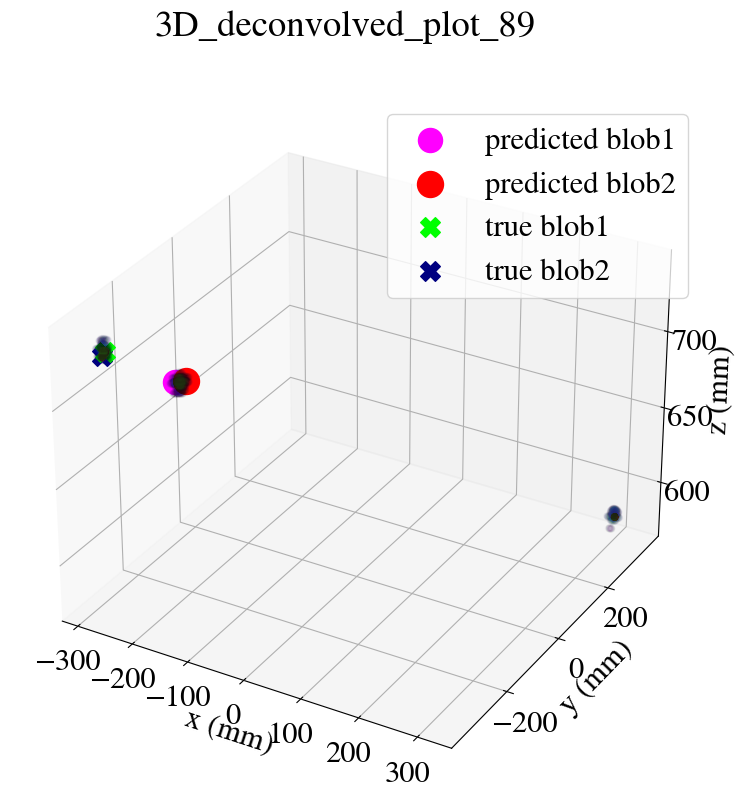

Selected event: 184 (92 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.34274 MeV
Track E: 1.34274


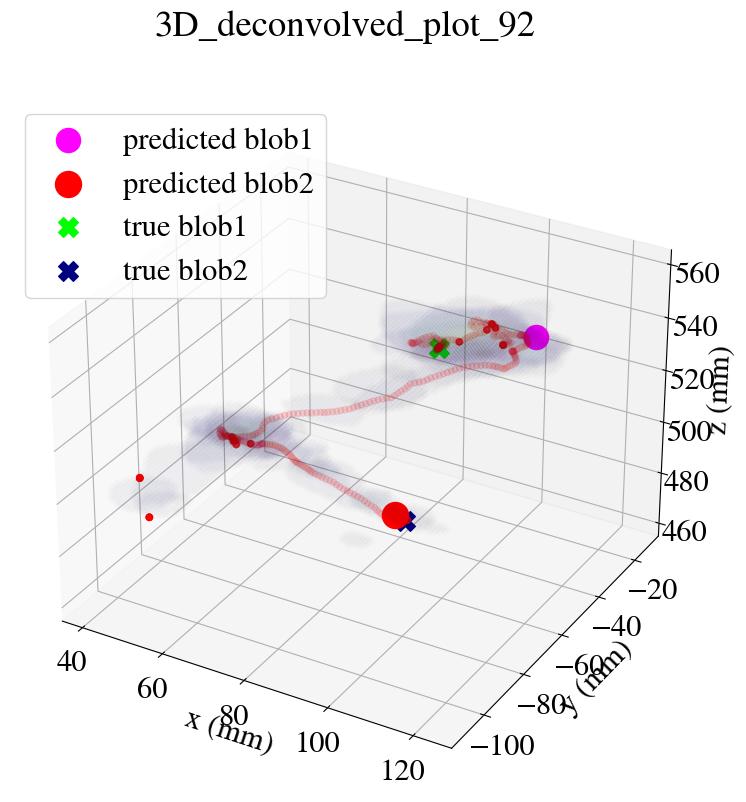

Selected event: 198 (99 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.59242 MeV
Track E: 1.42754


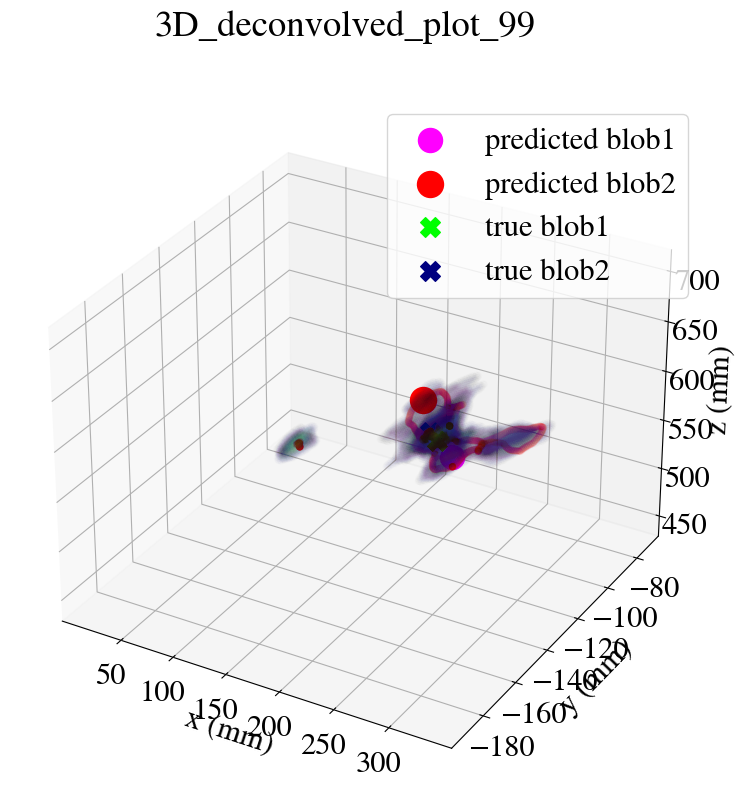

Selected event: 200 (100 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.43636 MeV
Track E: 1.43636


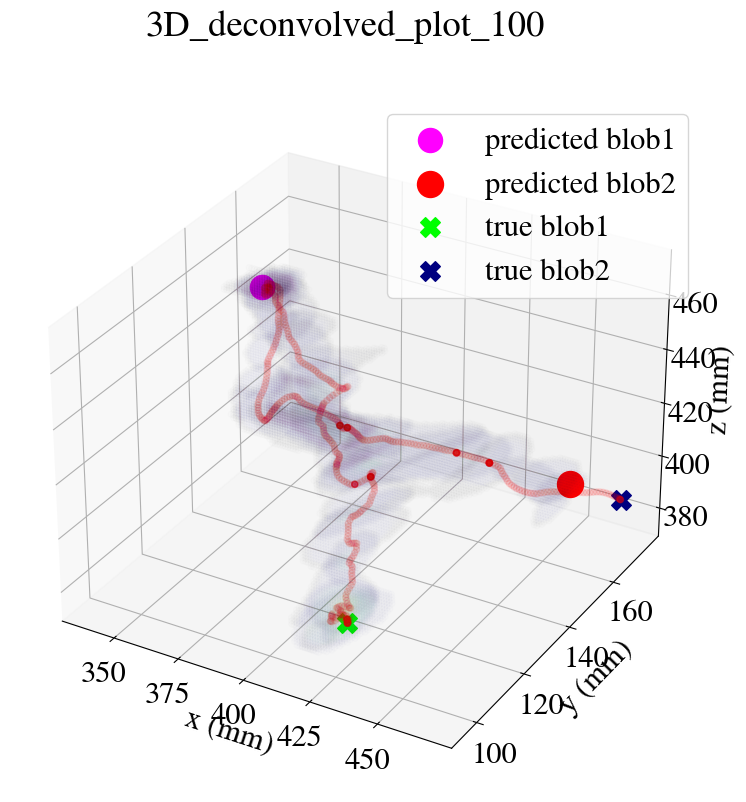

Selected event: 206 (103 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.31072 MeV
Track E: 2.31072


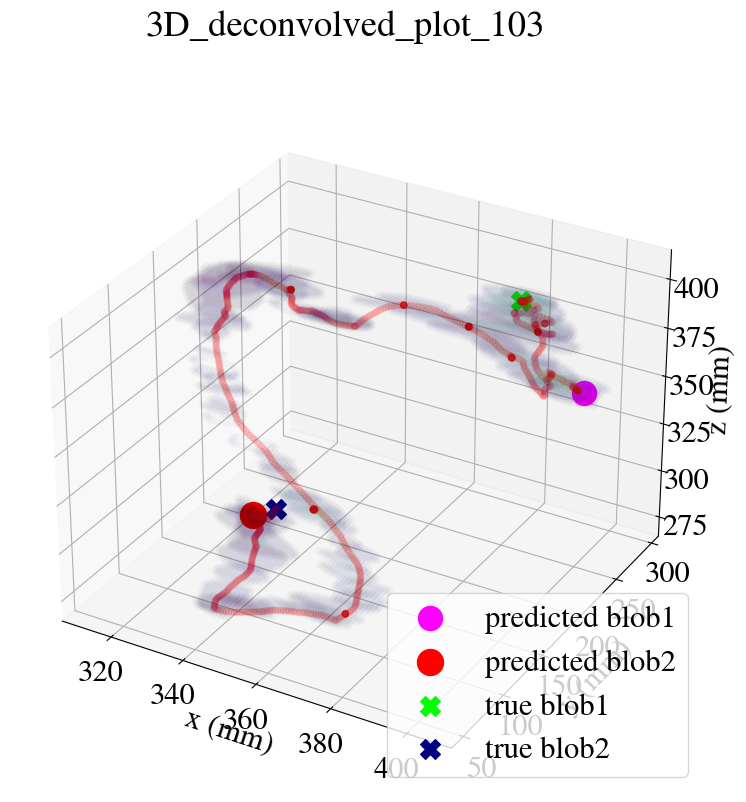

Selected event: 228 (114 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.59682 MeV
Track E: 0.59682


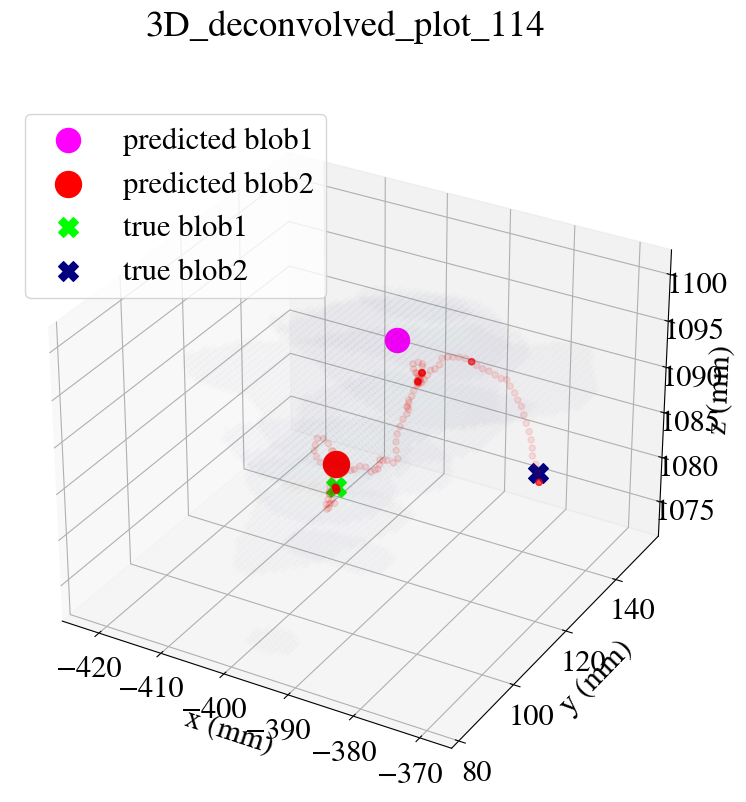

Selected event: 230 (115 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.39220 MeV
Track E: 2.28868


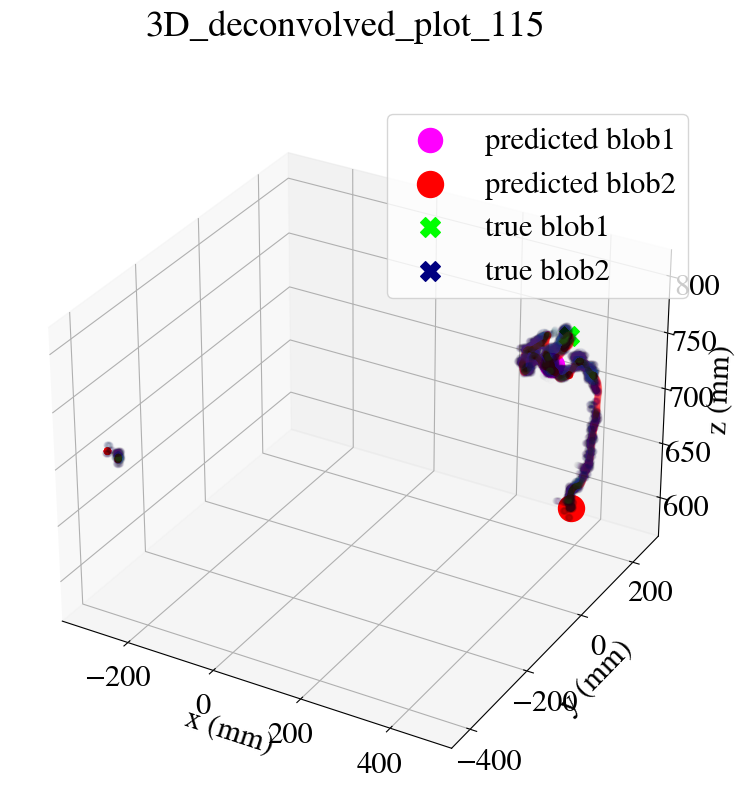

Selected event: 258 (129 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.78740 MeV
Track E: 0.78740


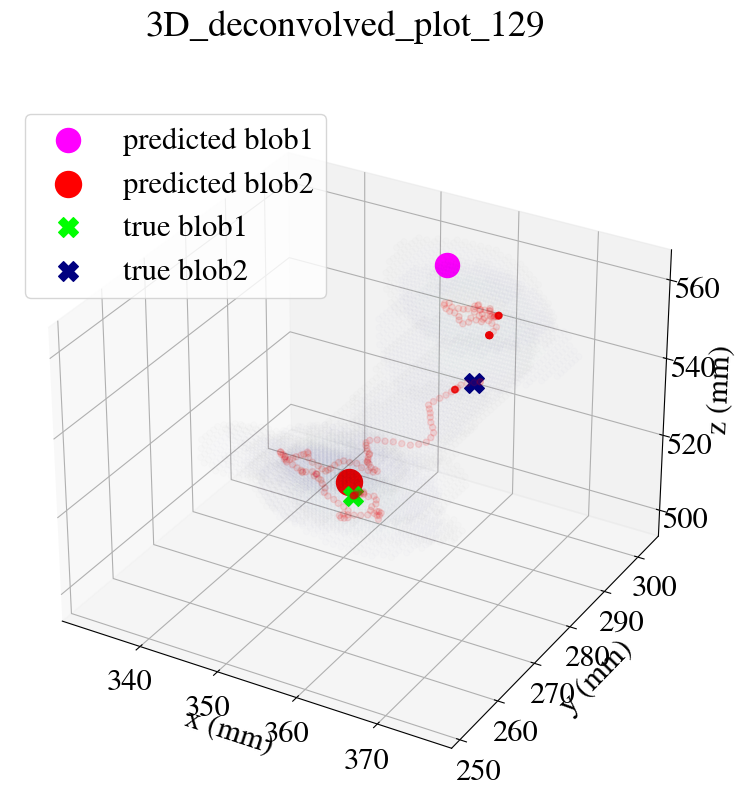

Selected event: 260 (130 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.64120 MeV
Track E: 0.29901


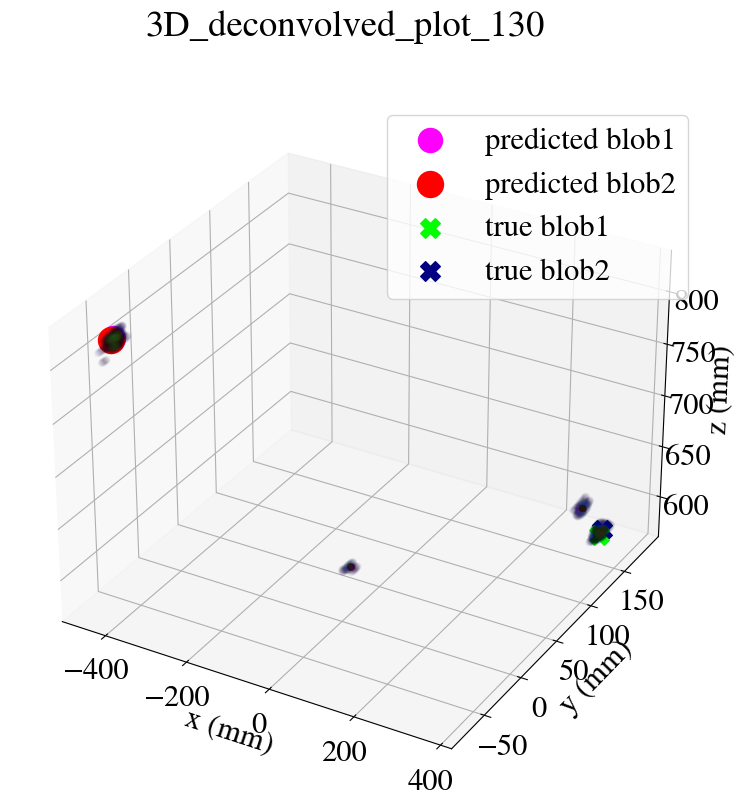

Selected event: 262 (131 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.40560 MeV
Track E: 0.19915


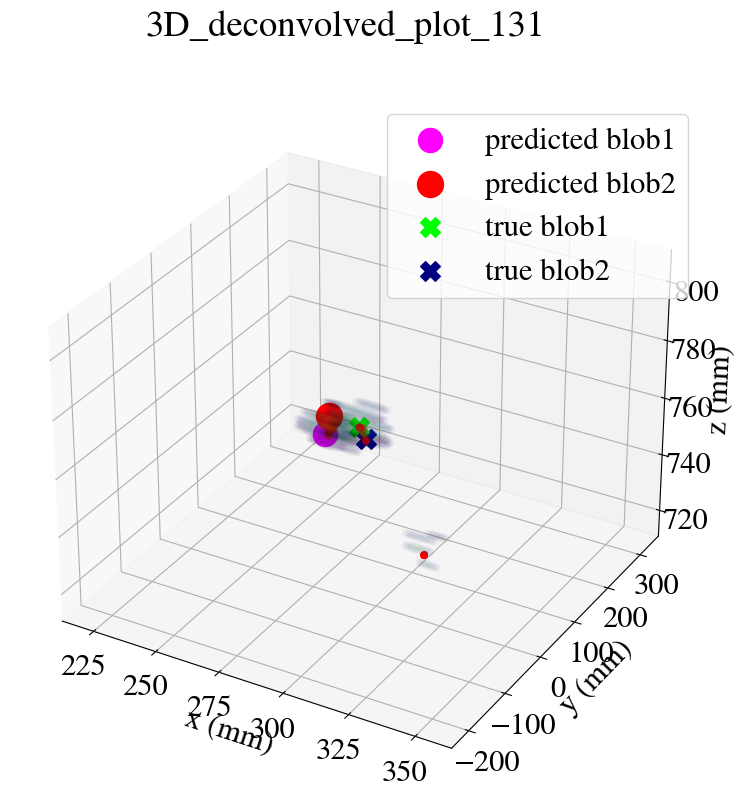

Selected event: 274 (137 MC)
Checking track energy and Beersheba energy:
Beersheba E: 2.08998 MeV
Track E: 1.54979


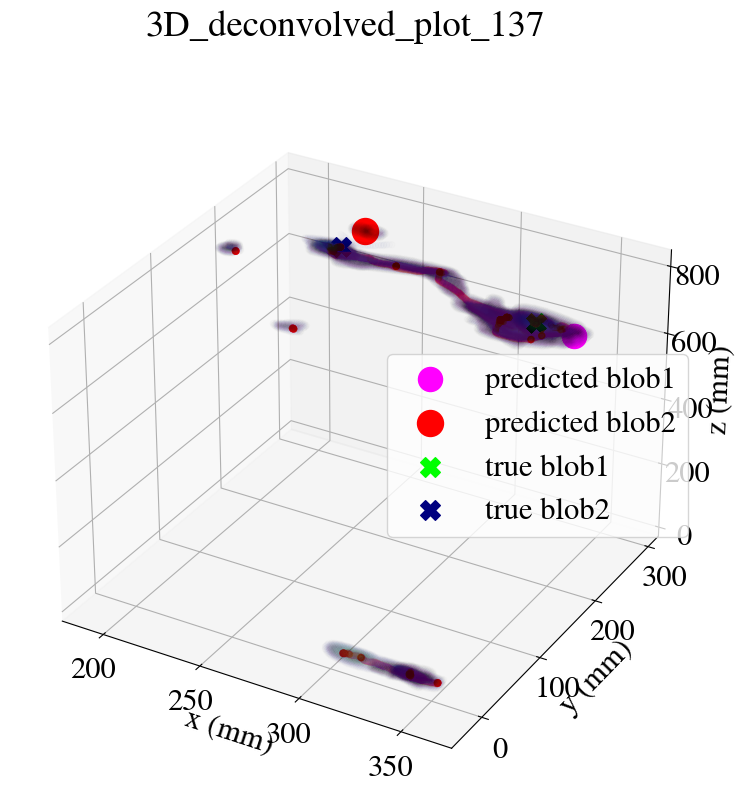

Selected event: 276 (138 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.57865 MeV
Track E: 0.50391


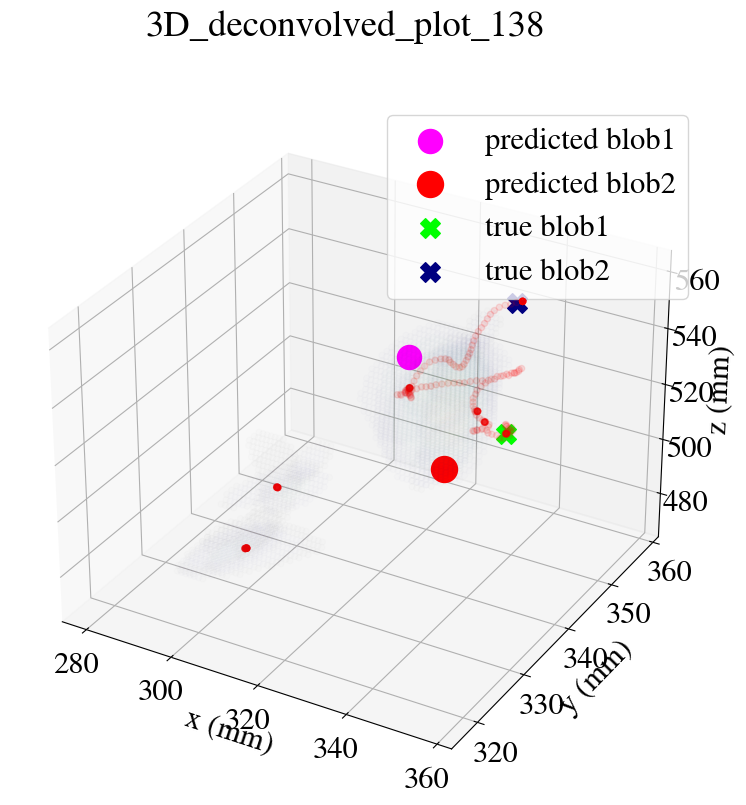

Selected event: 286 (143 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.30194 MeV
Track E: 1.30194


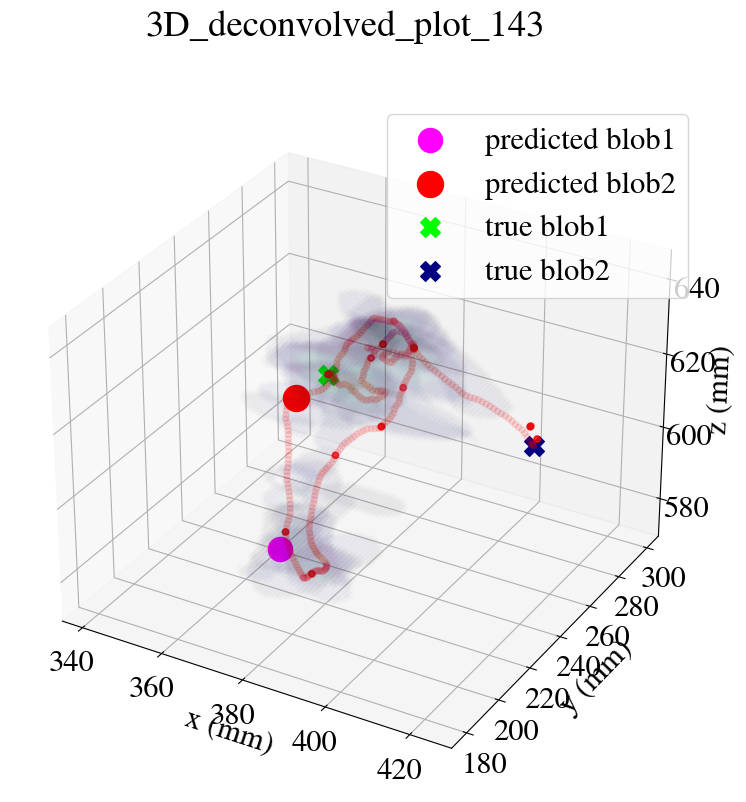

Selected event: 306 (153 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.51190 MeV
Track E: 0.50399


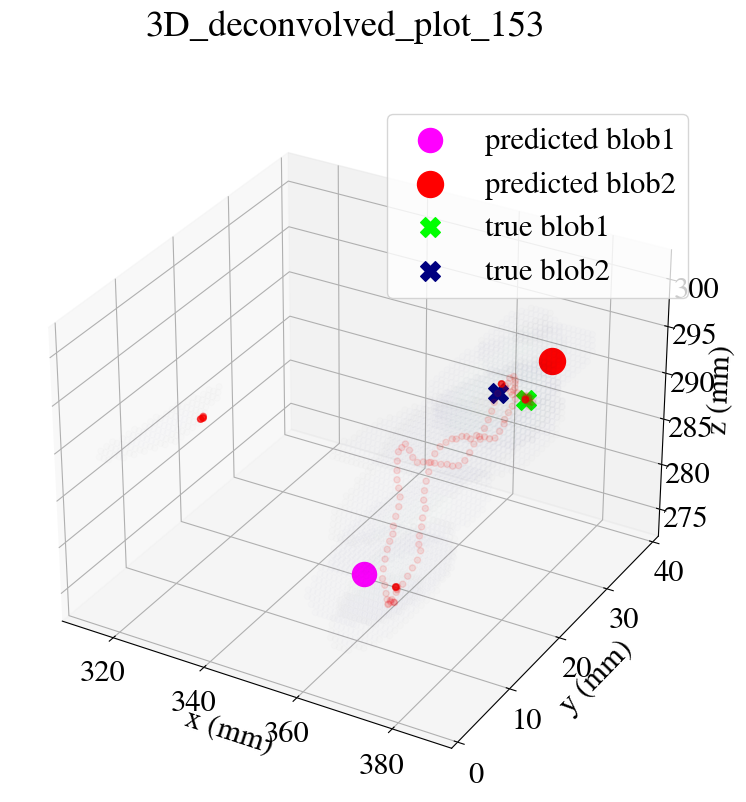

Selected event: 312 (156 MC)
Checking track energy and Beersheba energy:
Beersheba E: 0.61931 MeV
Track E: 0.61865


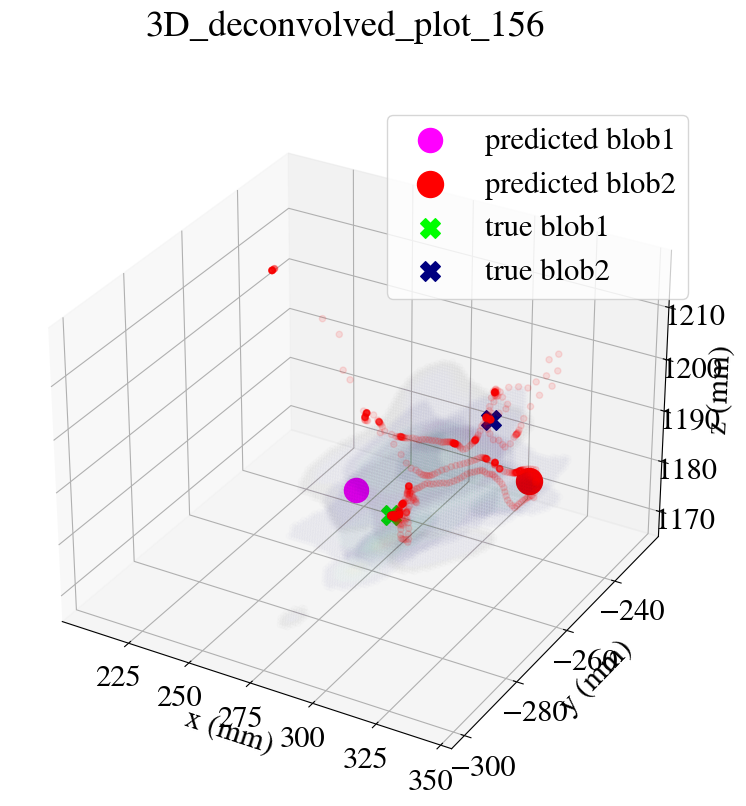

Selected event: 314 (157 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.33012 MeV
Track E: 1.33012


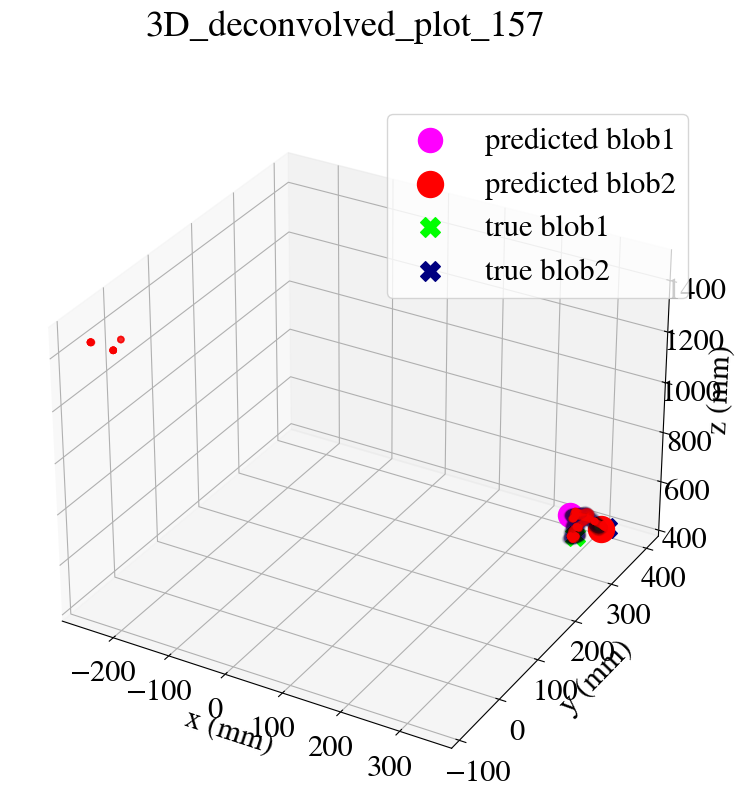

Selected event: 322 (161 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.55765 MeV
Track E: 1.55765


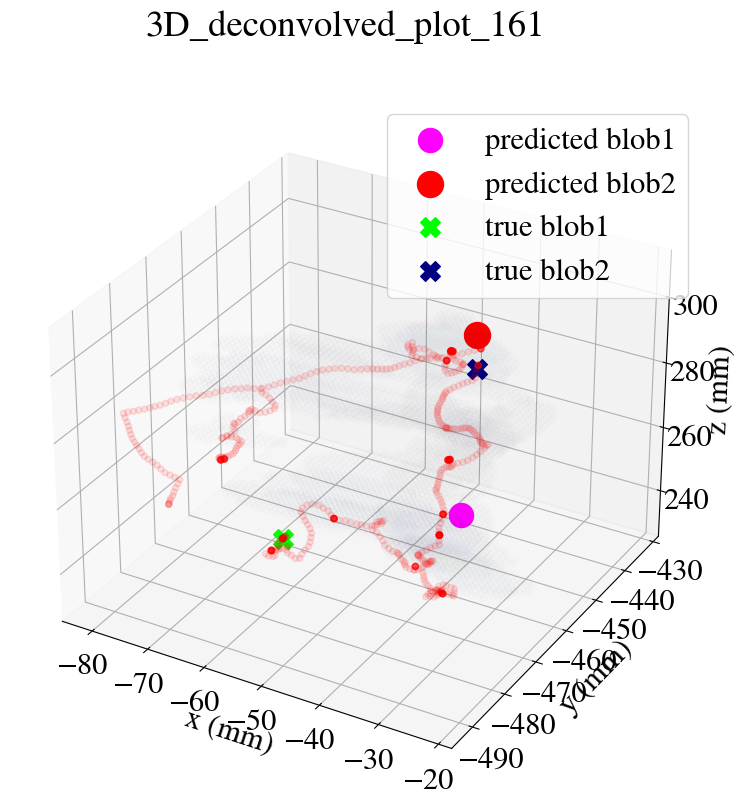

Selected event: 326 (163 MC)
Checking track energy and Beersheba energy:
Beersheba E: 1.90791 MeV
Track E: 1.86595


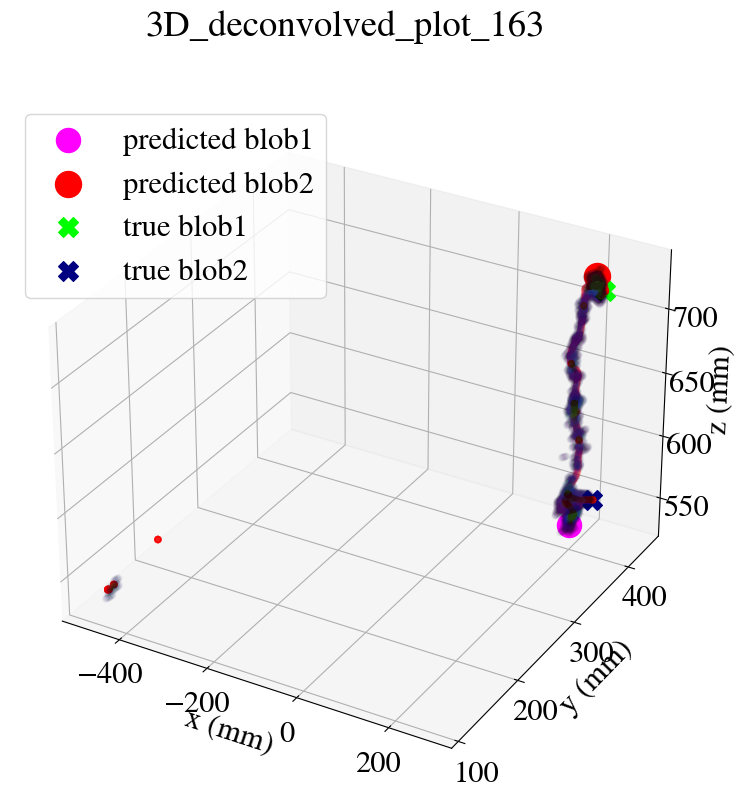

Reached limit, breaking loop


In [5]:
# read list of dodgy events
blob1_dodgy_events = np.load('blob1_anomalies.npy', allow_pickle=True)
blob2_dodgy_events = np.load('blob2_anomalies.npy', allow_pickle=True)


dodgy_evts = blob1_dodgy_events

# hard break
limit = 30



for i, evt_i in enumerate(dodgy_evts):



    # select an event

    evt = evt_i // 2

    print("Selected event: {} ({} MC)".format(evt_i, evt))

    data = df[df.event == evt_i]
    track_data = tracking[tracking.event == evt_i]
    dataMC = dfMC[dfMC.event_id == evt]
    evnt_infoMC = infoMC[infoMC.event_id == evt]

    evnt_mc_extr = mc_extr[mc_extr.event_id == evt]

    #display(data)
    #display(dataMC)
    #display(track_data)
    #display(evnt_infoMC)
    #display(evnt_mc_extr)

    # check energy
    print(f'Checking track energy and Beersheba energy:\nBeersheba E: {data.E.sum():.5f} MeV\nTrack E: {track_data.energy.values[0]:.5f}')

    plot_blobs(data, dataMC, track_data, evnt_mc_extr, evt)


    if i >= limit:
        print("Reached limit, breaking loop")
        break